In [8]:
struct scomp
    sequence::Vector{Float64}
    rate::Float64
end
struct fcomp
    sequence::Vector{Float64}
    rate::Float64
end
function ⨝(L::Float64, R::Float64)
    return 2*L*R/(L+R+sqrt(L^2+6*L*R+R^2))
end
function ▷(L::Float64, R::Float64)
    return 2*L*R/(L+4*R+sqrt(L^2+8*L*R))
end
function ⨝(L::scomp, R::scomp)
    l = L.rate
    r = R.rate
    sigmaL = (1 - L.rate) / L.rate
    sigmaR = (1 - R.rate) / R.rate
    prodL = L.rate
    prodR = R.rate

    mu = 1/2 * (-sigmaL - sigmaR + sqrt((4+prodL*prodR*(2+sigmaL+sigmaR)^2)/(prodL * prodR)))
    return scomp(
        vcat(L.sequence, [mu], R.sequence),
        (1/(1+sigmaL + sigmaR + mu))
    )
end
function ▷(L::scomp, R::fcomp)
    mu = 1 + (sqrt(1 + 8 * R.rate / L.rate) -1)/(4 * R.rate)
    return fcomp(
        vcat(L.sequence, [mu], R.sequence),
        (1/(1/R.rate + 2 * mu + 2 * (1/L.rate - 1)))
    )
end

▷ (generic function with 2 methods)

In [9]:
function computeSCompPivots(N)
    s_pivot = zeros(Int, N)
    s_rate = zeros(N)
    for i in 1:N
        s_pivot[i] =  floor(Int, i/2)
        L = (s_pivot[i]==0) ? 1.0 : s_rate[s_pivot[i]]
        R = (i - 1 - s_pivot[i]) ==0 ? 1.0 : s_rate[i - 1 - s_pivot[i]]
        s_rate[i] = L ⨝ R
    end
    return s_pivot, s_rate
end
function computeFCompPivots(N, s_pivot, s_rate)
    f_pivot = zeros(Int, N)
    f_rate = zeros(N)
    f_pivot[1] = 0
    f_rate[1] = 0.25
    for i in 2:N
        m = i>1 ? f_pivot[i-1] : 0
        L = (m==0) ? 1.0 : s_rate[m]
        R = (i - 1 - m) ==0 ? 1.0 : f_rate[i - 1 - m]
        rate1 = L ▷ R
        m = m+1
        L = (m==0) ? 1.0 : s_rate[m]
        R = (i - 1 - m) <=0 ? 1.0 : f_rate[i - 1 - m]
        rate2 = L ▷ R
        
        if rate1 < rate2
            f_pivot[i] = m-1
            f_rate[i] = rate1
        else
            f_pivot[i] = m
            f_rate[i] = rate2
        end
    end
    return f_pivot
end
function OBS_S_with_pivots(N, s_pivot)
    if N==0
        return scomp([],1.0)
    else
        p = s_pivot[N]
        return OBS_S_with_pivots(p, s_pivot) ⨝ OBS_S_with_pivots(N-1-p, s_pivot)
    end
end
function OBS_S(N)
    s_pivot, _ = computeSCompPivots(N)
    return OBS_S_with_pivots(N, s_pivot)
end    
function OBS_F_with_pivots(N,s_pivot,f_pivot)
    if N==0
        return fcomp([],1.0)
    else
        p = f_pivot[N]
        return OBS_S_with_pivots(p,s_pivot) ▷ OBS_F_with_pivots(N-1-p,s_pivot,f_pivot)
    end
end
function OBS_F(N)
    s_pivot, s_rate = computeSCompPivots(N)
    f_pivot = computeFCompPivots(N, s_pivot, s_rate)
    return OBS_F_with_pivots(N,s_pivot,f_pivot)
end

OBS_F (generic function with 1 method)

# Generating Plots of OBS-F Stepsizes

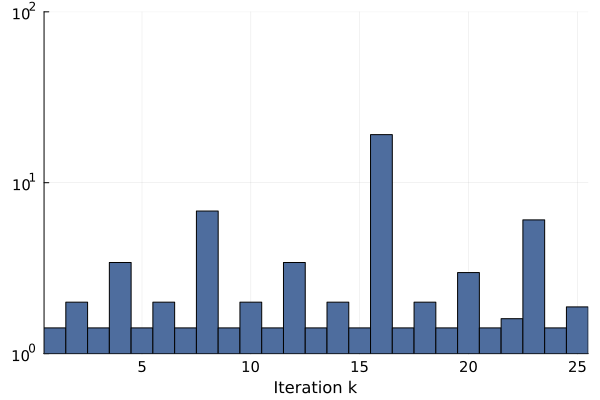

In [11]:
using Plots
using Printf

dark_blue_color = RGB(78/255, 109/255, 158/255)

N=25
p = bar(OBS_F(N).sequence, 
    color=dark_blue_color, 
    yscale=:log10, 
    legend=false, 
    yticks = [1,10,100],
    ylims = (1,100),
#    xticks=0:10:N,  # Optional: Set x-ticks at intervals
    xlims=(0.5, N+0.5),   # Set x-axis limits from 0 to 100
    xlabel="Iteration k", 
#    ylabel="Conjectured Minimax Optimal Schedule", 
    bar_width=1.0,  # Ensure bars touch each other
#    grid=false,  # Optionally turn off the grid if you prefer
    tick_direction=:in,
    tickfontsize=10
)